# Activity 5.9
## Association Mining of South Korean COVID-19 case route data

In [18]:
# Imports

import pandas as pd

import matplotlib.pyplot as plt

from apyori import apriori

from collections import defaultdict
import subprocess
import re

In [19]:
# Load the data

route_df = pd.read_csv('data/PatientRoute-1.csv')

### Examine the structure and content of the dataset

In [20]:
# Examine the structure of the dataset
route_df.head(5)

,patient_id,global_num,date,location,latitude,longitude
0,1000000001,2.0,22/01/2020,Gyeonggi-do_Gimpo-si,37.615246,126.715632
1,1000000001,2.0,24/01/2020,Seoul_Jung-gu,37.567241,127.005659
2,1000000002,5.0,25/01/2020,Seoul_Seongbuk-gu,37.592560,127.017048
3,1000000002,5.0,26/01/2020,Seoul_Seongbuk-gu,37.591810,127.016822
4,1000000002,5.0,26/01/2020,Seoul_Seongdong-gu,37.563992,127.029534


In [21]:
route_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6714 entries, 0 to 6713
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   patient_id  6714 non-null   int64  
 1   global_num  3571 non-null   float64
 2   date        6714 non-null   object 
 3   location    6714 non-null   object 
 4   latitude    6714 non-null   float64
 5   longitude   6714 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 314.8+ KB


In [22]:
route_df.date = pd.to_datetime(route_df.date)

In [23]:
num_patients = len(route_df.patient_id.unique())
num_locations = len(route_df.location.unique())

print(f"In this dataset there are {len(route_df)} datapoints for {num_patients} unique patients and {num_locations} unique locations.")

In this dataset there are 6714 datapoints for 1211 unique patients and 174 unique locations.


In [24]:
route_df.location.value_counts()

Chungcheongnam-do_Cheonan-si       470
Seoul_Gangnam-gu                   293
Gangwon-do_Wonju-si                275
Gyeongsangbuk-do_Yecheon-gun       257
Seoul_Guro-gu                      206
                                  ... 
Jeollabuk-do_Iksan-si                1
Gyeongsangbuk-do_Cheongsong-gun      1
Gyeongsangbuk-do_Gimcheon-si         1
Busan_Yeongdo-gu                     1
Gyeongsangnam-do_Goseong-gun         1
Name: location, Length: 174, dtype: int64

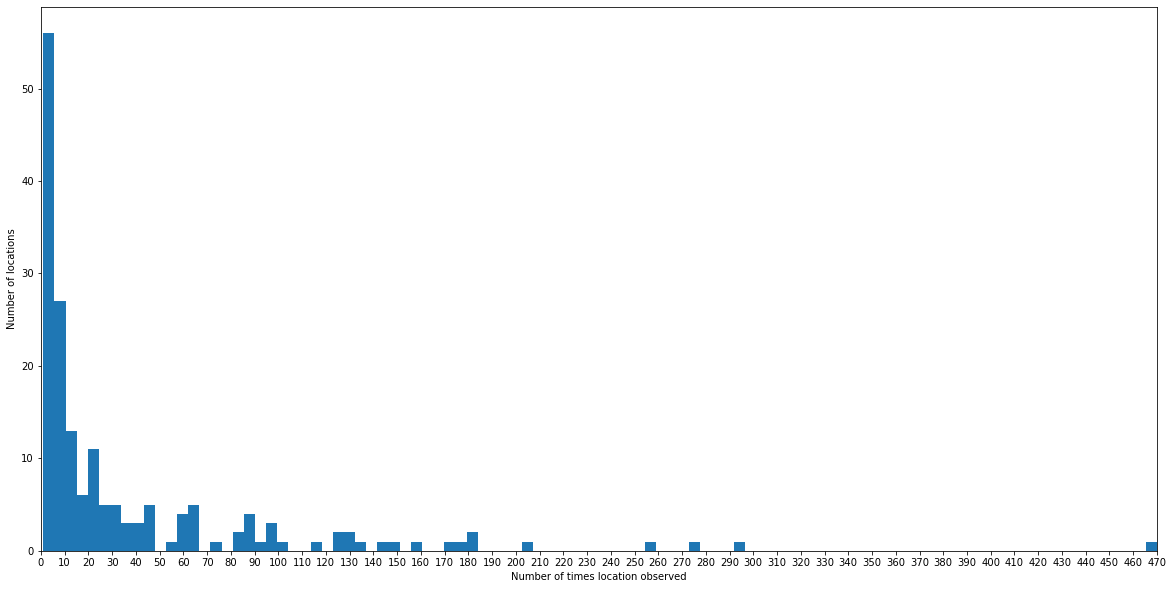

In [25]:
# How often do unique locations appear in the dataset?
plt.figure(figsize=(20,10))

route_df.location.value_counts().plot(kind='hist', bins=100)

plt.xticks(range(0,500, 10))

plt.xlabel("Number of times location observed")
plt.ylabel("Number of locations")

plt.xlim(0,470)

plt.savefig("")

plt.show()

<AxesSubplot:ylabel='Frequency'>

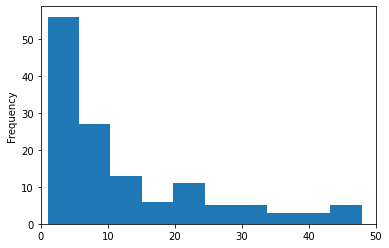

In [26]:
# Examining where the bulk of the data lies

route_df.location.value_counts().plot(kind='hist', bins=100, xlim=(0,50))

### Apriori algorithm association mining

In [27]:
# We can consider each patient as a transaction, and convert the locations they visited into a list

routes = route_df.groupby(['patient_id'])['location'].apply(list)

routes.head(5)

patient_id
1000000001                [Gyeonggi-do_Gimpo-si, Seoul_Jung-gu]
1000000002    [Seoul_Seongbuk-gu, Seoul_Seongbuk-gu, Seoul_S...
1000000003                   [Seoul_Jongno-gu, Seoul_Jongno-gu]
1000000004                                  [Seoul_Jungnang-gu]
1000000005                                  [Seoul_Jungnang-gu]
Name: location, dtype: object

#### What is the ‘min_support’ threshold set? Discuss why it is chosen.
Despite the reasonably large number of patients and unique locations, examining the histogram above we can see that many locations are reported relatively few times. A large proportion of the locations are reported less than 10 times. Given this in conjunction with the importance of identifying travel between areas for tracking the spread of COVID-19, we will want a relatively low support threshold. To start with, let us examine all locations that occur at least twice in the dataset. Calculating our support threshold in this manner -> 2 / 1211 = 0.00165

##### Further data preparation and running of the apriori algorithm

In [28]:
# Conver the routes into a list that can be utilised by the apyori package

routes_list = list(routes)

In [29]:
results = list(apriori(routes_list, min_support=0.00165))

# print first 5 rules
print(results[:5])

[RelationRecord(items=frozenset({'Busan_Buk-gu'}), support=0.008257638315441783, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Busan_Buk-gu'}), confidence=0.008257638315441783, lift=1.0)]), RelationRecord(items=frozenset({'Busan_Busanjin-gu'}), support=0.017341040462427744, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Busan_Busanjin-gu'}), confidence=0.017341040462427744, lift=1.0)]), RelationRecord(items=frozenset({'Busan_Dong-gu'}), support=0.011560693641618497, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Busan_Dong-gu'}), confidence=0.011560693641618497, lift=1.0)]), RelationRecord(items=frozenset({'Busan_Dongnae-gu'}), support=0.03468208092485549, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'Busan_Dongnae-gu'}), confidence=0.03468208092485549, lift=1.0)]), RelationRecord(items=frozenset({'Busan_Gangseo-gu'}), support=0.0090834021469

In [30]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                         rule_set.support, rule.confidence, rule.lift]) 
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) 

result_df = convert_apriori_results_to_pandas_df(results)

print(result_df.head(20))

   Left_side                         Right_side   Support  Confidence  Lift
0                                  Busan_Buk-gu  0.008258    0.008258   1.0
1                             Busan_Busanjin-gu  0.017341    0.017341   1.0
2                                 Busan_Dong-gu  0.011561    0.011561   1.0
3                              Busan_Dongnae-gu  0.034682    0.034682   1.0
4                              Busan_Gangseo-gu  0.009083    0.009083   1.0
5                            Busan_Geumjeong-gu  0.009083    0.009083   1.0
6                              Busan_Gijang-gun  0.002477    0.002477   1.0
7                             Busan_Haeundae-gu  0.026424    0.026424   1.0
8                                 Busan_Jung-gu  0.006606    0.006606   1.0
9                                  Busan_Nam-gu  0.006606    0.006606   1.0
10                                Busan_Saha-gu  0.008258    0.008258   1.0
11                              Busan_Sasang-gu  0.004129    0.004129   1.0
12          

#### Report the top 5 frequently occurring rules and interpret them.

In [52]:
# Most frequent means rules with the most support, so we can sort in this way

result_df.sort_values(by='Support', ascending=False).head(5)

,Left_side,Right_side,Support,Confidence,Lift
92,,Incheon_Jung-gu,0.123865,0.123865,1.0
112,,Seoul_Gangnam-gu,0.086705,0.086705,1.0
108,,Seoul_Dongjak-gu,0.085879,0.085879,1.0
22,,Chungcheongnam-do_Cheonan-si,0.078448,0.078448,1.0
120,,Seoul_Jungnang-gu,0.075970,0.075970,1.0


The top 5 most common rules all have an empty "left hand side". This means that irrespective of the other location(s) involved, the 5 locations specified above will occur with a probability equal to thier confidence. If we were only interested in common changes in location (routes travelled) we could examine rules that have only non-empty left hand sides.

In [53]:
result_df[result_df.Left_side != ''].sort_values(by='Support', ascending=False).head(5)

,Left_side,Right_side,Support,Confidence,Lift
1005,Seoul_Gangnam-gu,Incheon_Jung-gu,0.030553,0.352381,2.844889
1004,Incheon_Jung-gu,Seoul_Gangnam-gu,0.030553,0.246667,2.844889
1037,Incheon_Jung-gu,Seoul_Songpa-gu,0.020644,0.166667,3.669697
1038,Seoul_Songpa-gu,Incheon_Jung-gu,0.020644,0.454545,3.669697
479,Chungcheongnam-do_Asan-si,Chungcheongnam-do_Cheonan-si,0.017341,0.750000,9.560526


#### Identify at least 10 common routes that positive patients from ‘Daegu_Buk-gu’ have travelled.<br>

As above, most common can be interpreted as having the most support.

In [45]:
result_df[result_df.Left_side == 'Daegu_Buk-gu'].sort_values(by='Support', ascending=False).head(10)

,Left_side,Right_side,Support,Confidence,Lift
509,Daegu_Buk-gu,Daegu_Jung-gu,0.015690,0.487179,7.866325
527,Daegu_Buk-gu,Gyeongsangbuk-do_Pohang-si,0.009083,0.282051,8.758054
512,Daegu_Buk-gu,Daegu_Nam-gu,0.004129,0.128205,10.350427
2012,Daegu_Buk-gu,"Daegu_Nam-gu,Daegu_Jung-gu",0.004129,0.128205,17.250712
524,Daegu_Buk-gu,Gyeongsangbuk-do_Gyeongsan-si,0.003303,0.102564,3.268556
506,Daegu_Buk-gu,Daegu_Dong-gu,0.003303,0.102564,5.175214
1998,Daegu_Buk-gu,"Daegu_Dong-gu,Daegu_Jung-gu",0.003303,0.102564,11.291375
2075,Daegu_Buk-gu,"Daegu_Nam-gu,Daegu_Seo-gu",0.002477,0.076923,23.288462
3193,Daegu_Buk-gu,"Daegu_Nam-gu,Daegu_Jung-gu,Daegu_Seo-gu",0.002477,0.076923,31.051282
3223,Daegu_Buk-gu,"Seoul_Jung-gu,Daegu_Nam-gu,Daegu_Jung-gu",0.002477,0.076923,31.051282


Another option I was contemplating for this:
- From Daegu_Buk-gu could be interpretted as this location being on the RHS of the rule, this might enable generation of the 10 rules they want with a higher min_support

#### Can you perform sequence analysis on this dataset? If yes, present your results. If not, rationalise why.

In [33]:
# Visual inspection of the CSV shows the locations are reported in ascending date order for each patient
# If they were not we would need to iterate through each patient and sort the dates

sequences = routes.values.tolist()

Shamelessly steal the function from the Module 5 notebook

In [34]:
''' Uses SPMF to find association rules in supplied transactions '''
def get_association_rules(sequences, min_sup, min_conf):
    # step 1: create required input for SPMF
    
    # prepare a dict to uniquely assign each item in the transactions to an int ID
    item_dict = defaultdict(int)
    output_dict = defaultdict(str)
    item_id = 1
    
    # write your sequences in SPMF format
    with open('seq_rule_input.txt', 'w+') as f:
        for sequence in sequences:
            z = []
            for itemset in sequence:
                # if there are multiple items in one itemset
                if isinstance(itemset, list):
                    for item in itemset:
                        if item not in item_dict:
                            item_dict[item] = item_id
                            item_id += 1

                        z.append(item_dict[item])
                else:
                    if itemset not in item_dict:
                        item_dict[itemset] = item_id
                        output_dict[str(item_id)] = itemset
                        item_id += 1
                    z.append(item_dict[itemset])
                    
                # end of itemset
                z.append(-1)
            
            # end of a sequence
            z.append(-2)
            f.write(' '.join([str(x) for x in z]))
            f.write('\n')
    
    # run SPMF with supplied parameters
    supp_param = '{}%'.format(int(min_sup * 100))
    conf_param = '{}%'.format(int(min_conf * 100))
    subprocess.call(['java', '-jar', 'spmf.jar', 'run', 'RuleGrowth', 'seq_rule_input.txt', 'seq_rule_output.txt', supp_param, conf_param], shell=True)
    
    # read back the output rules
    outputs = open('seq_rule_output.txt', 'r').read().strip().split('\n')
    output_rules = []
    for rule in outputs:
        left, right, sup, conf = re.search(pattern=r'([0-9\,]+) ==> ([0-9\,]+) #SUP: ([0-9]+) #CONF: ([0-9\.]+)', string=rule).groups()
        sup = int(sup) / len(sequences)
        conf = float(conf)
        output_rules.append([[output_dict[x] for x in left.split(',')], [output_dict[x] for x in right.split(',')], sup, conf])
    
    # return pandas DataFrame
    return pd.DataFrame(output_rules, columns = ['Left_rule', 'Right_rule', 'Support', 'Confidence'])

In [41]:
get_association_rules(sequences, 0.00165, 0.2).sort_values(by='Support', ascending=False).head(10)

,Left_rule,Right_rule,Support,Confidence
3325,[Incheon_Jung-gu],[Seoul_Gangnam-gu],0.029727,0.240000
19381,[Chungcheongnam-do_Asan-si],[Chungcheongnam-do_Cheonan-si],0.016515,0.714286
3007,[Seoul_Songpa-gu],[Seoul_Jungnang-gu],0.015690,0.345455
17235,[Busan_Dongnae-gu],[Busan_Yeonje-gu],0.014864,0.428571
8276,[Daegu_Jung-gu],[Daegu_Buk-gu],0.014038,0.226667
17733,[Busan_Haeundae-gu],[Busan_Yeonje-gu],0.012386,0.468750
18526,[Busan_Busanjin-gu],[Busan_Yeonje-gu],0.010735,0.619048
9370,[Seoul_Gwanak-gu],[Seoul_Dongjak-gu],0.009909,0.285714
7585,[Seoul_Seocho-gu],[Seoul_Dongjak-gu],0.008258,0.222222
9848,[Seoul_Gangseo-gu],[Seoul_Yangcheon-gu],0.008258,0.312500


All of the sequence rules generated have relatively low levels of support, which is consistent with the overall low prevalence of many locations within the dataset. However, several of the rules have a relatively high confidence. This can be interpreted as the sequence of locations (route travelled) occuring in this order with a probability equal to the confidence.

#### How can the outcome of this study be used by the decision-makers?

- Identify COVID-19 hotspots based on levels of support for individual locations
- Identify locations that are likely to be linked in terms of case transmission (using the association rules generated)
- Identify potential routes of transmission to new areas utilising the rules generated by the sequence association rules
- This can enable:
    - Targetted testing of areas which are linked
    - Limitation of travel along specific routes
    - Enhance contact tracing, even without specific knowledge regarding a cases movements